In [ ]:
import numpy as np
import open3d as o3d
import os
from PIL import Image
import matplotlib.pyplot as plt
from utilities import *
from ICP import run_icp
from NDT import run_ndt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
src_path = "kitti_sample/00/000000.bin"
tgt_path = "kitti_sample/00/000005.bin"

source = load_pcd(src_path)
target = load_pcd(tgt_path)

In [7]:
o3d.visualization.draw_geometries([source])

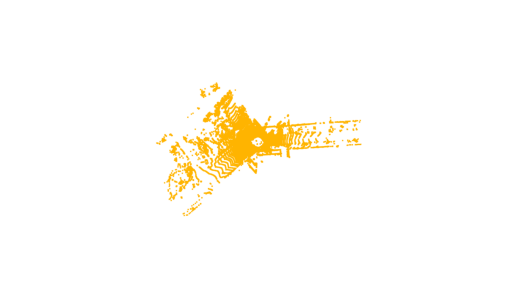

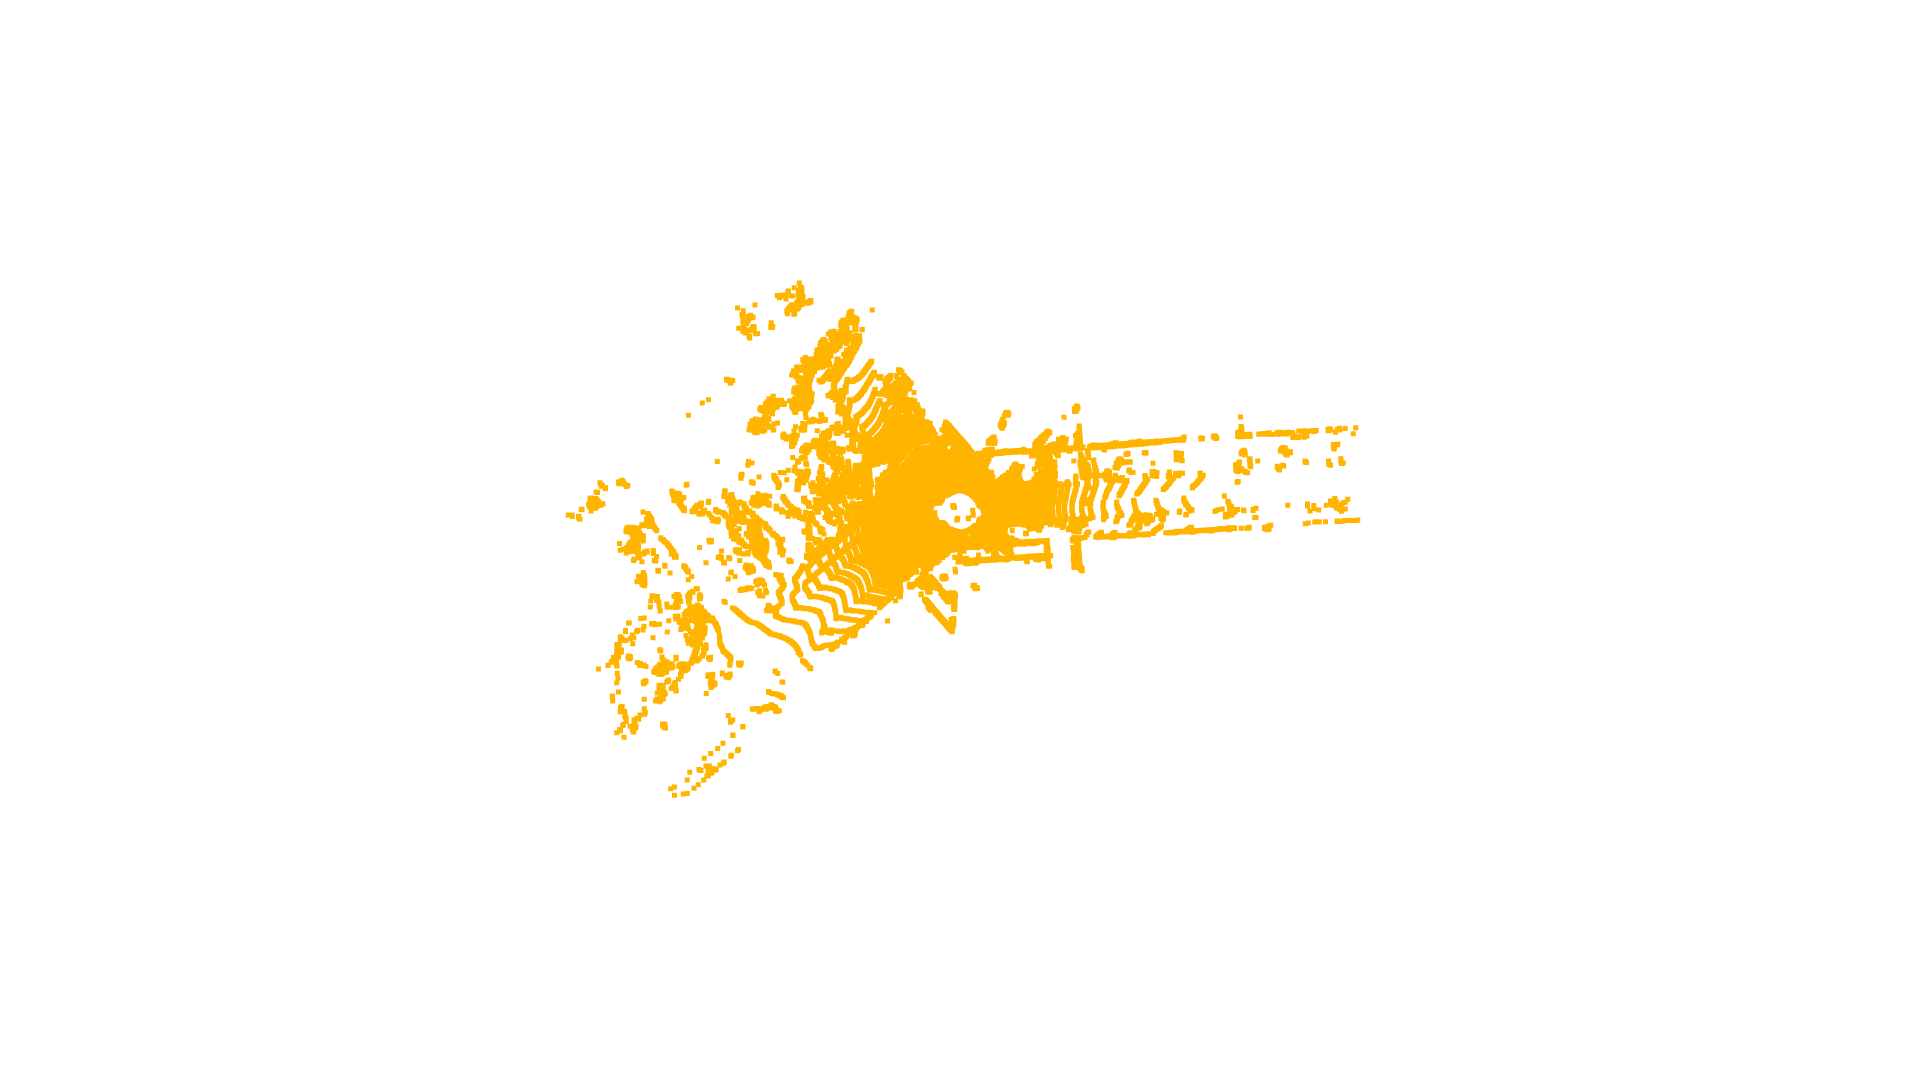

In [ ]:
a = plot_pcd(source)

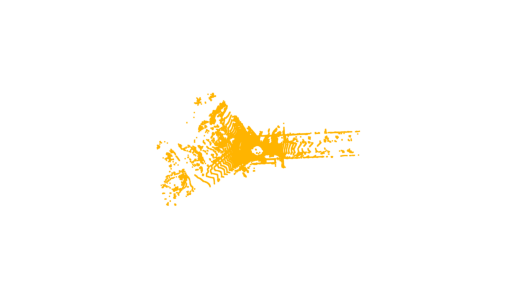

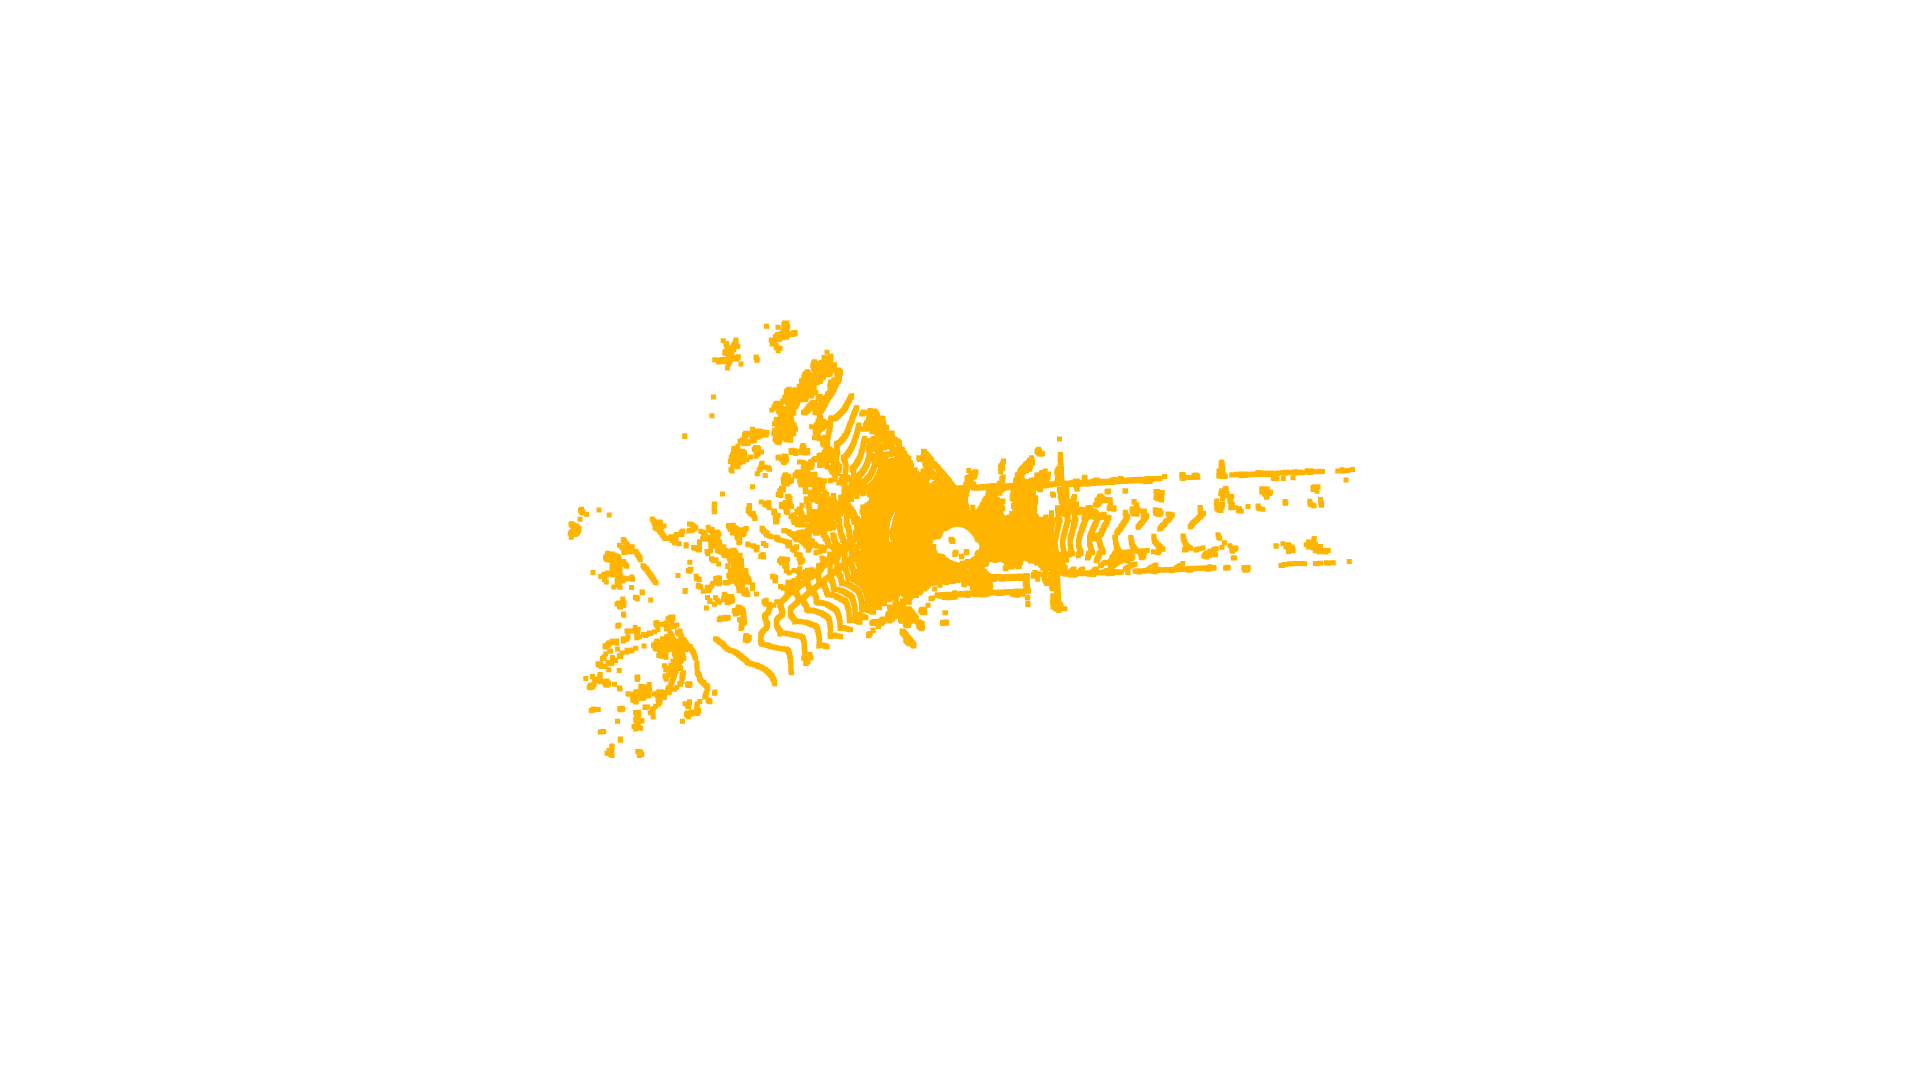

In [ ]:
a = plot_pcd(target)

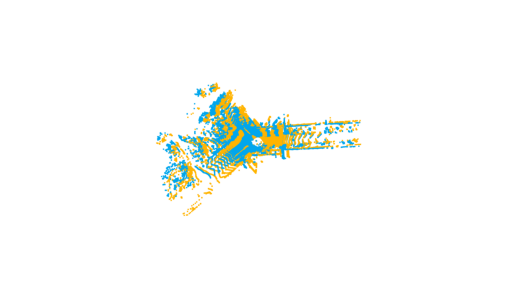

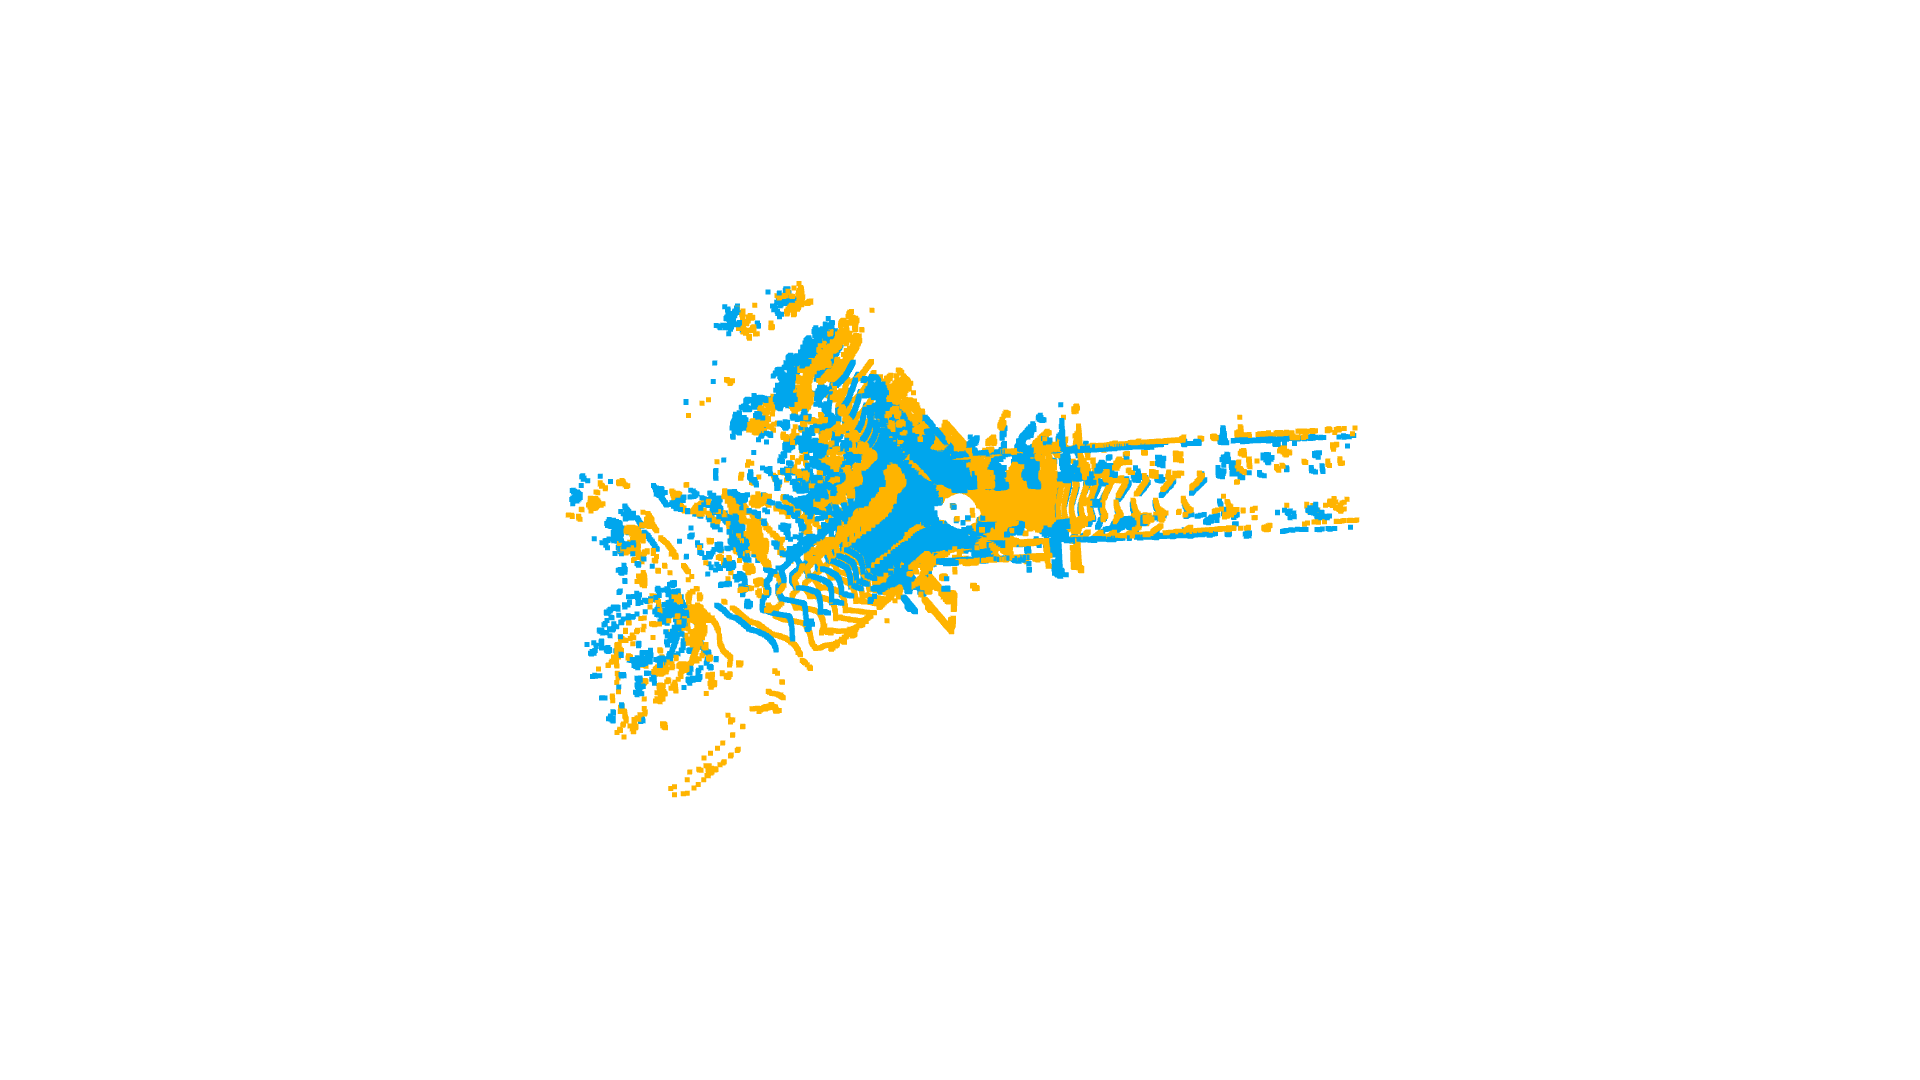

In [ ]:
a = plot_pcd([source,target])

In [11]:
threshold = 1.0  # max correspondence point-pair distance
trans_init = np.eye(4)
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
source_temp = copy.deepcopy(source)
transformed_pcd = source_temp.transform(reg_p2p.transformation)

RegistrationResult with fitness=8.627876e-01, inlier_rmse=3.300695e-01, and correspondence_set size of 107562
Access transformation to get result.
Transformation is:
[[ 9.99681612e-01  2.50121588e-02  3.32653806e-03 -4.29363839e-01]
 [-2.50137747e-02  9.99687008e-01  4.45037546e-04  1.96837310e-01]
 [-3.31436553e-03 -5.28105125e-04  9.99994368e-01 -1.27137403e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


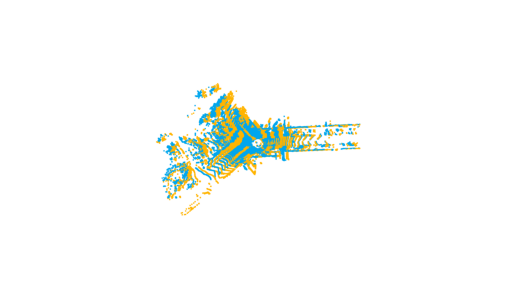

In [12]:
img = plot_pcd([transformed_pcd,target])

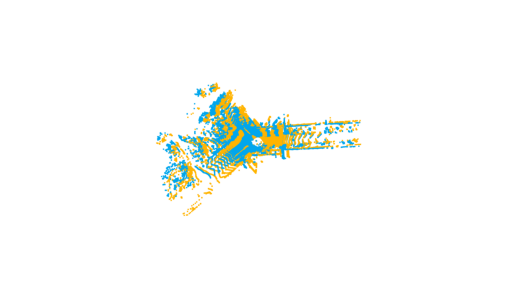

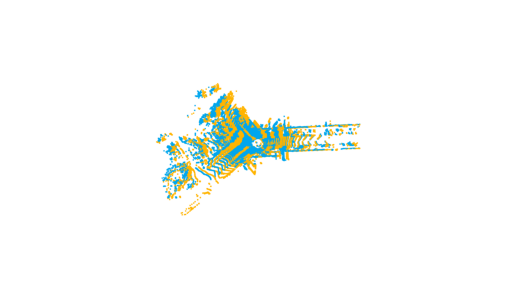

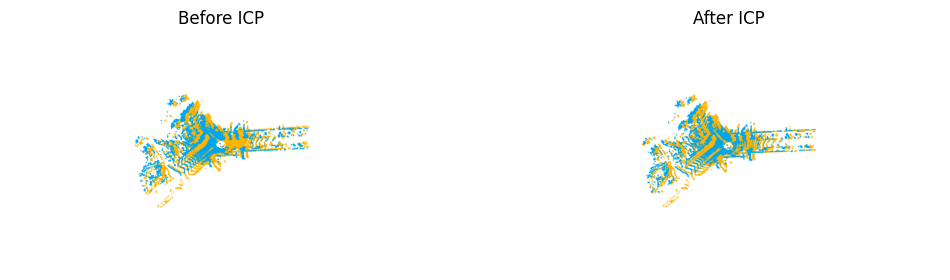

In [ ]:

img_before = plot_pcd([source,target])
img_after  = plot_pcd([transformed_pcd,target] )
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_before)
axes[0].set_title("Before ICP")
axes[0].axis('off')
axes[1].imshow(img_after)
axes[1].set_title("After ICP")
axes[1].axis('off')
plt.show()

RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.216609e-01, and correspondence_set size of 124668
Access transformation to get result.
Transformation is:
[[ 9.99318235e-01  3.68552205e-02  2.18108812e-03 -3.73000806e+00]
 [-3.68539199e-02  9.99320463e-01 -6.33559262e-04  1.58698705e-01]
 [-2.20295596e-03  5.52745677e-04  9.99997421e-01  4.36028400e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


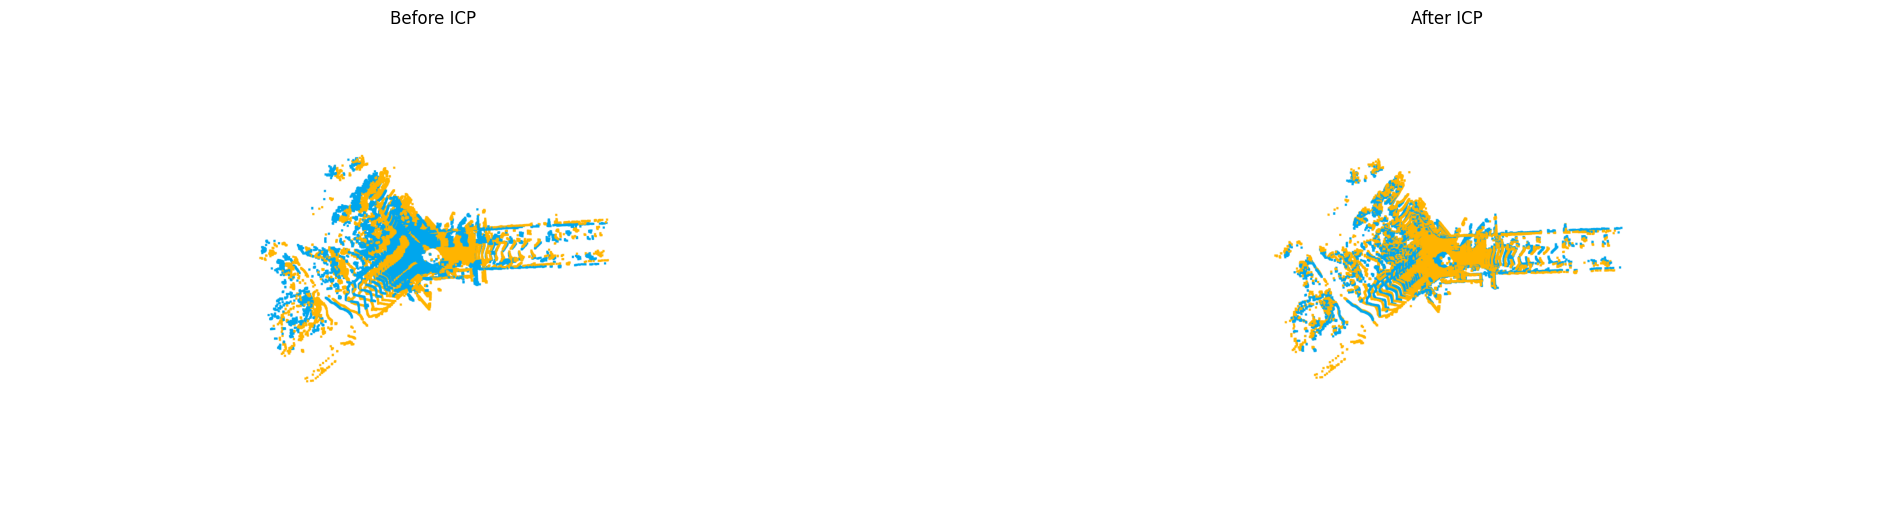

[[ 9.99318235e-01  3.68552205e-02  2.18108812e-03 -3.73000806e+00]
 [-3.68539199e-02  9.99320463e-01 -6.33559262e-04  1.58698705e-01]
 [-2.20295596e-03  5.52745677e-04  9.99997421e-01  4.36028400e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
src_path = "kitti_sample/00/000000.bin"
tgt_path = "kitti_sample/00/000005.bin"

source = load_pcd(src_path)
target = load_pcd(tgt_path)

transformed_new_pcd, transformation_matrix = run_icp(source, target, threshold=2.0, max_iteration=3000)
print(transformation_matrix)

draw_registration_result(source , target , transformation_matrix)

In [ ]:
o3d.visualization.draw_geometries([run_icp(source , target , threshold = 15 , max_iteration= 30000 )[0]])

In [ ]:
run_icp(source , target , threshold = 15 , max_iteration= 30000 )[1]

array([[ 9.99318235e-01,  3.68552205e-02,  2.18108812e-03,
        -3.73000806e+00],
       [-3.68539199e-02,  9.99320463e-01, -6.33559262e-04,
         1.58698705e-01],
       [-2.20295596e-03,  5.52745677e-04,  9.99997421e-01,
         4.36028400e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [18]:
o3d.visualization.draw_geometries([source , target])

# 2

In [ ]:
import random
random.seed(42)
from utilities import load_pcd
import numpy as np
from ICP import run_icp
import open3d as o3d

icp_poses = []  

transformation_matrix = np.eye(4)
sum_pcd = load_pcd(f"kitti_sample/00/000000.bin")
sum_pcd.paint_uniform_color([random.random(), random.random(), random.random()])
voxel_downsize = 0.9

for idx in range(0, 141):
    
    new_pcd = load_pcd(f"kitti_sample/00/{idx:06d}.bin")
    new_pcd = new_pcd.voxel_down_sample(voxel_downsize)
    
    transformed_new_pcd, transformation_matrix , fit, rmse = run_icp(new_pcd, sum_pcd, trans_init= transformation_matrix , threshold=2.0, max_iteration=300)
    transformed_new_pcd.paint_uniform_color([random.random(), random.random(), random.random()])
    sum_pcd = sum_pcd + transformed_new_pcd
    
    sum_pcd.voxel_down_sample(voxel_downsize)
    
    icp_poses.append(transformation_matrix) 
    print(f"[{idx:03d}] fit={fit:.3f}, rmse={rmse:.3f}, t={transformation_matrix[:3,3]}")


icp_poses = np.stack(icp_poses, axis=0)   
np.save("icp_poses.npy", icp_poses)
o3d.io.write_point_cloud("icp_pcd.ply", sum_pcd)
print("Saved ICP:", icp_poses.shape, "poses for frames")

[000] fit=1.000, rmse=0.115, t=[ 0.0075475  -0.00775839 -0.00576782]
[001] fit=0.983, rmse=0.432, t=[0.75214751 0.04063104 0.02585877]
[002] fit=0.997, rmse=0.331, t=[1.42889361 0.01992565 0.02226388]
[003] fit=0.999, rmse=0.289, t=[2.1331291  0.01231071 0.01847265]
[004] fit=0.999, rmse=0.248, t=[2.87127611 0.01789194 0.02882363]
[005] fit=1.000, rmse=0.234, t=[3.59518121 0.04350666 0.02779434]
[006] fit=0.999, rmse=0.213, t=[4.37849764 0.05639197 0.04132893]
[007] fit=0.999, rmse=0.206, t=[5.16468405 0.08921908 0.04560501]
[008] fit=1.000, rmse=0.197, t=[5.96243151 0.15012733 0.04377115]
[009] fit=1.000, rmse=0.216, t=[6.81443723 0.18314983 0.0589245 ]
[010] fit=0.999, rmse=0.222, t=[7.59652813 0.20761861 0.06078186]
[011] fit=0.999, rmse=0.193, t=[8.38448481 0.2336947  0.07435497]
[012] fit=0.998, rmse=0.207, t=[9.21786759 0.27968774 0.07181552]
[013] fit=0.987, rmse=0.199, t=[10.06512239  0.3219323   0.08676405]
[014] fit=0.983, rmse=0.231, t=[10.95139787  0.4113745   0.08658054]
[

In [85]:
o3d.io.write_point_cloud("icp_pcd.ply", sum_pcd)

True

In [100]:
o3d.visualization.draw_geometries([sum_pcd])

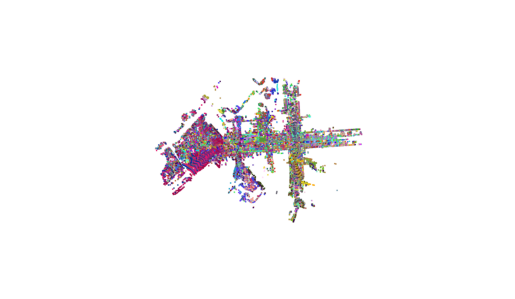

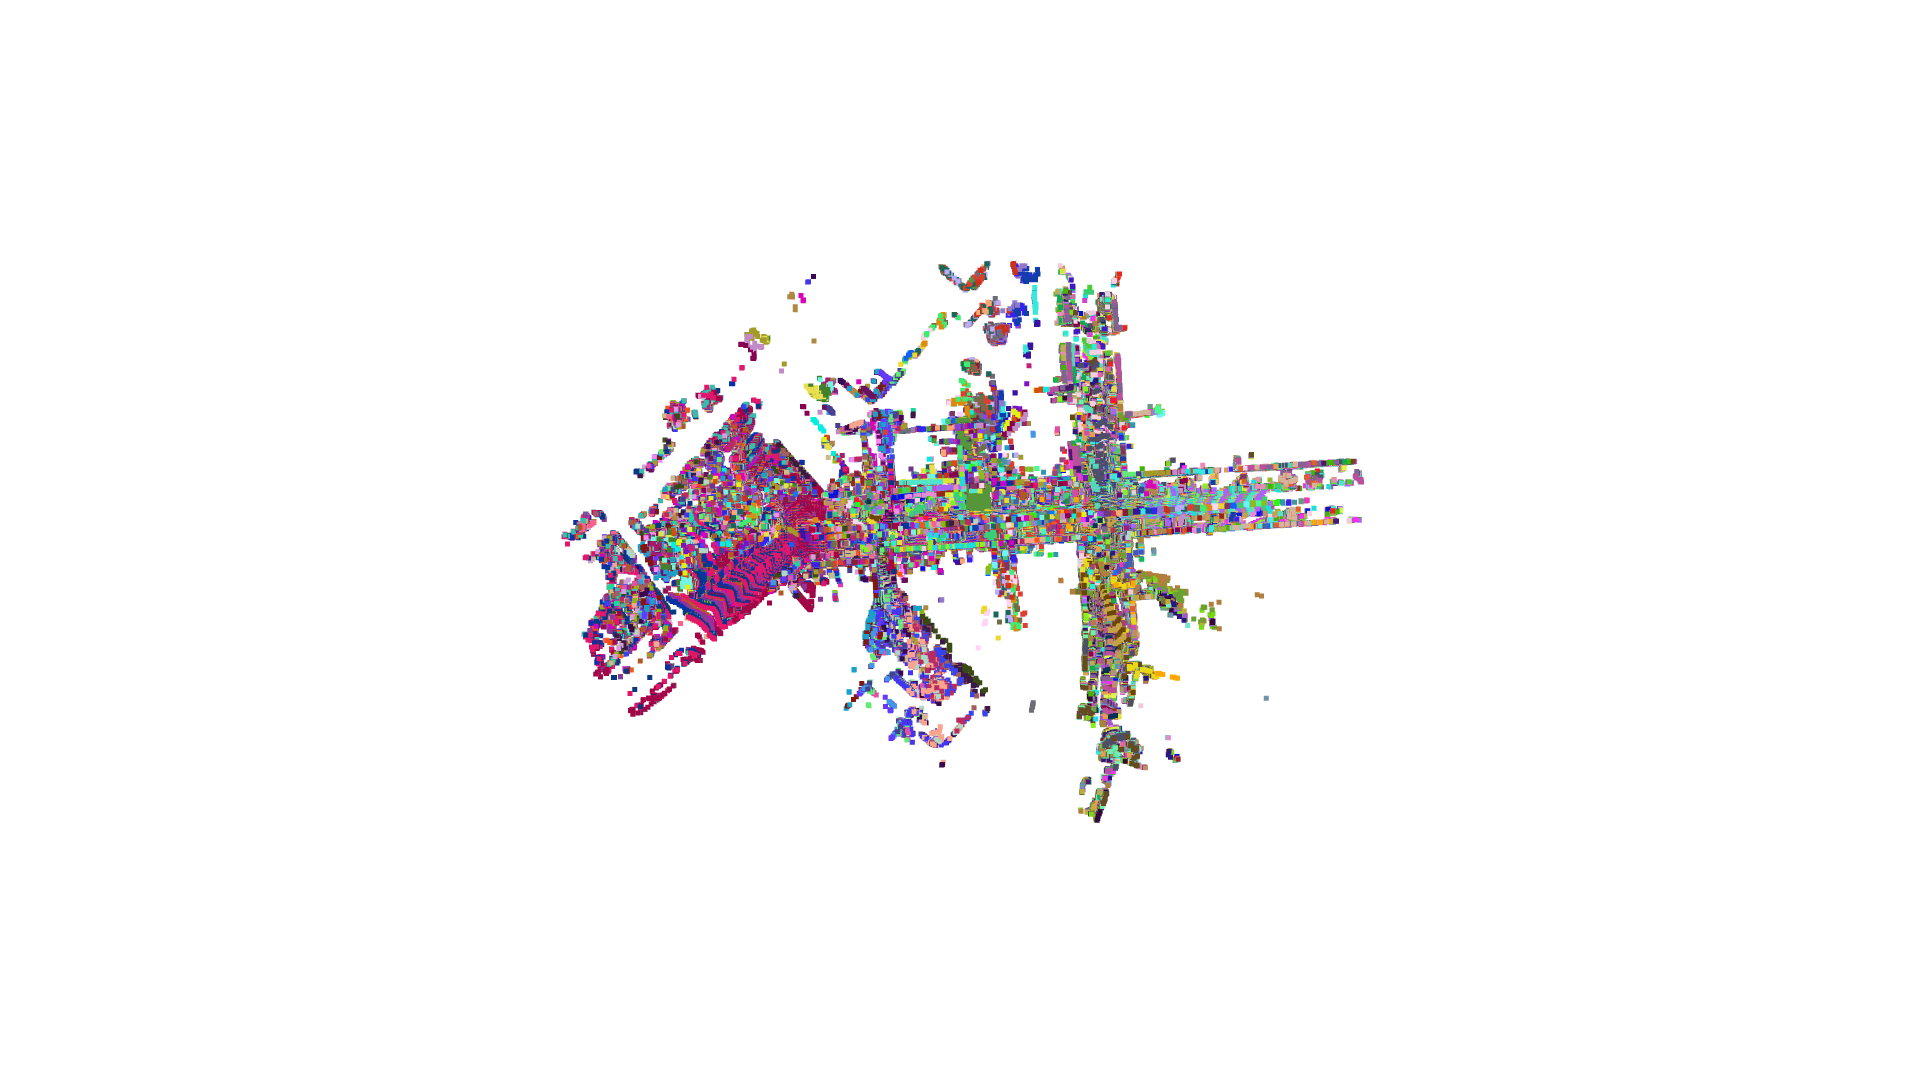

In [99]:
plot_pcd(sum_pcd)

# 3)


In [ ]:
import random
random.seed(42)
from utilities import load_pcd
import numpy as np
from NDT import run_ndt
import open3d as o3d

ndt_poses = []  
transformation_matrix = np.eye(4)
sum_pcd = load_pcd(f"00/000000.bin")
sum_pcd.paint_uniform_color([random.random(), random.random(), random.random()])
voxel_downsize = 0.9

for idx in range(0, 141):
    
    new_pcd = load_pcd(f"00/{idx:06d}.bin")
    new_pcd = new_pcd.voxel_down_sample(voxel_downsize)
    
    transformed_new_pcd, transformation_matrix = run_ndt(new_pcd, sum_pcd, trans_init= transformation_matrix)
    
    transformed_new_pcd.paint_uniform_color([random.random(), random.random(), random.random()])
    sum_pcd = sum_pcd + transformed_new_pcd
    
    sum_pcd.voxel_down_sample(voxel_downsize)
    
    ndt_poses.append(transformation_matrix) 
    print(f"[{idx:03d}], t={transformation_matrix[:3,3]}")


ndt_poses = np.stack(ndt_poses, axis=0)   
np.save("ndt_poses.npy", ndt_poses)
o3d.io.write_point_cloud("ndt_pcd.ply", sum_pcd)
print("Saved NDT:", ndt_poses.shape, "poses for frames")

[001] t=(0.562, 0.501, -0.034)
[002] t=(1.097, 0.667, -0.042)
[003] t=(1.756, 0.687, -0.041)
[004] t=(2.904, 0.548, -0.040)
[005] t=(3.372, 0.640, -0.029)
[006] t=(3.981, 0.656, -0.016)
[007] t=(4.942, 0.666, -0.006)
[008] t=(5.638, 0.716, -0.009)
[009] t=(6.504, 0.745, -0.003)
[010] t=(7.196, 0.777, 0.009)
[011] t=(8.103, 0.798, 0.010)
[012] t=(8.940, 0.837, 0.008)
[013] t=(9.803, 0.865, 0.017)
[014] t=(10.554, 0.911, 0.013)
[015] t=(11.465, 0.950, 0.021)
[016] t=(12.368, 1.003, 0.030)
[017] t=(13.269, 1.061, 0.032)
[018] t=(14.200, 1.072, 0.043)
[019] t=(15.069, 1.134, 0.048)
[020] t=(15.971, 1.163, 0.059)
[021] t=(16.890, 1.211, 0.067)
[022] t=(17.701, 1.425, 0.058)
[023] t=(18.609, 1.198, 0.074)
[024] t=(19.526, 1.371, 0.087)
[025] t=(20.447, 1.406, 0.095)
[026] t=(21.381, 1.518, 0.079)
[027] t=(22.318, 1.536, 0.102)
[028] t=(23.257, 1.572, 0.104)
[029] t=(24.204, 1.630, 0.097)
[030] t=(25.148, 1.679, 0.100)
[031] t=(26.096, 1.706, 0.116)
[032] t=(27.060, 1.754, 0.102)
[033] t=(28.

True

In [10]:
o3d.visualization.draw_geometries([sum_pcd])

In [6]:
o3d.io.write_point_cloud("ndtPCD.pcd", sum_pcd)

True

In [28]:
ndt_pcd = o3d.io.read_point_cloud("ndtPCD.pcd")

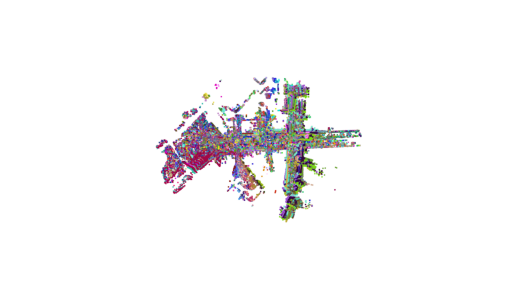

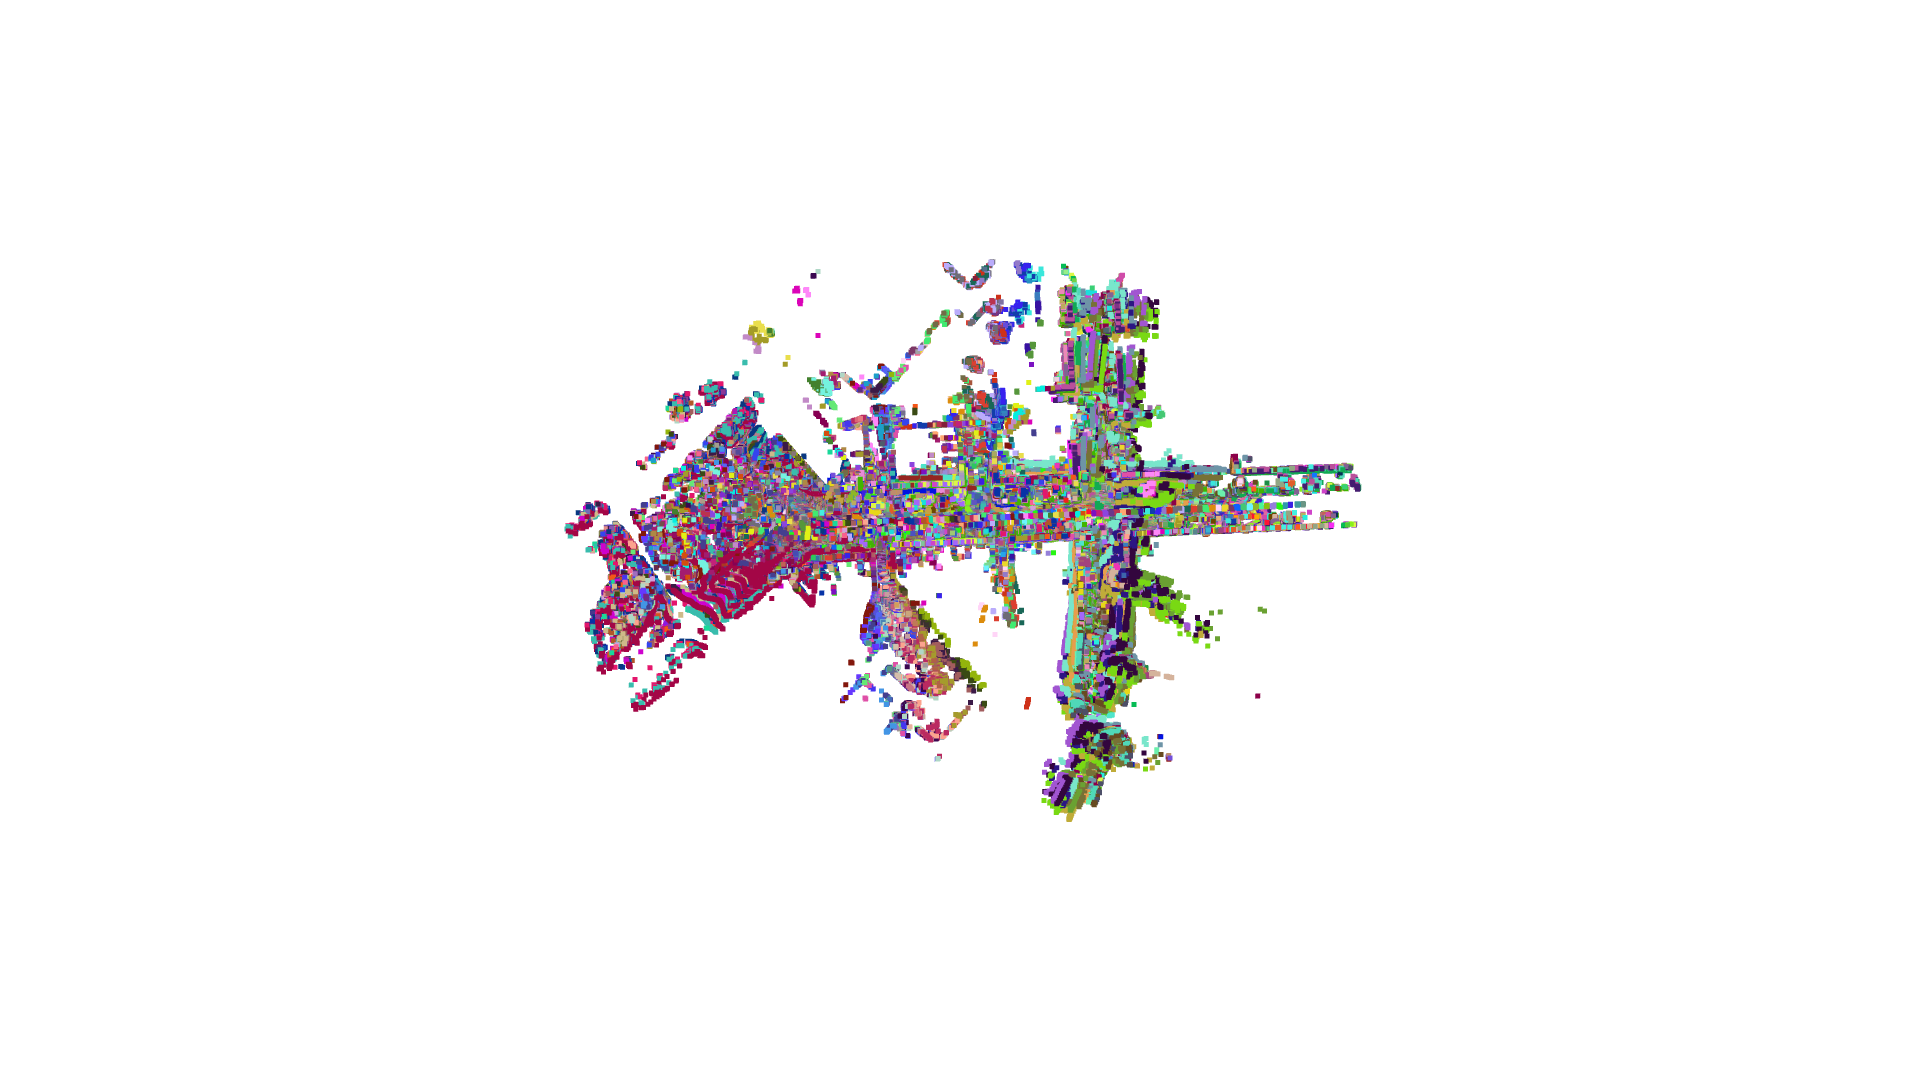

In [29]:
plot_pcd(ndt_pcd)

In [6]:
o3d.visualization.draw_geometries([ndt_pcd.voxel_down_sample(0.05)])
# o3d.visualization.draw_geometries([ndt_pcd])

In [6]:
o3d.visualization.draw_geometries([sum_pcd.voxel_down_sample(0.05)])

In [3]:
o3d.visualization.draw_geometries([sum_pcd])

## 4)

In [11]:
def FDE(x_est, y_est, x_gt, y_gt):
    return np.linalg.norm([x_est[-1] - x_gt[-1], y_est[-1] - y_gt[-1]])

def ADE(x_est, y_est, x_gt, y_gt):
    return np.mean(np.sqrt((x_est - x_gt)**2 + (y_est - y_gt)**2))


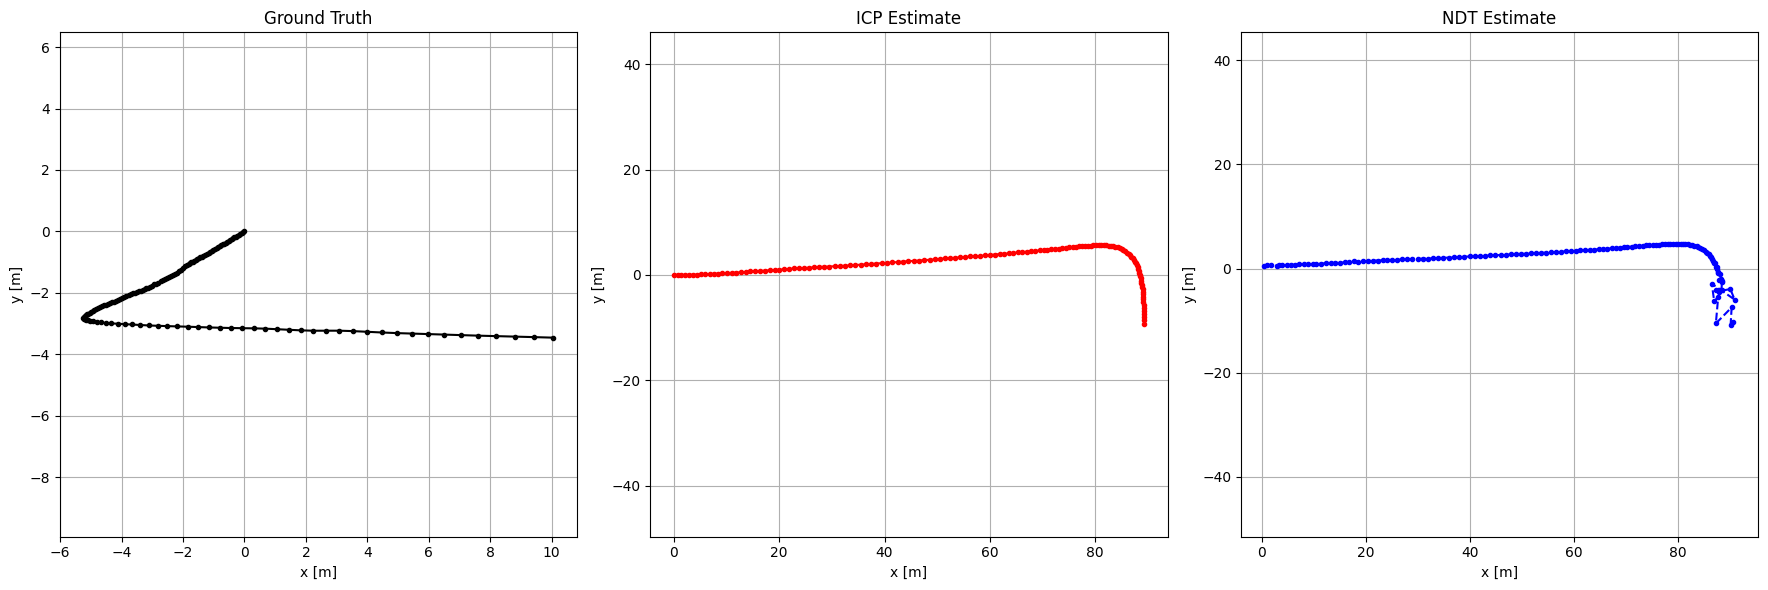

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your saved data
icp_poses  = np.load("icp_poses.npy")    # shape (N, 4, 4)
icp_frames = np.load("icp_frames.npy")
ndt_poses  = np.load("ndt_poses.npy")
ndt_frames = np.load("ndt_frames.npy")

# 2) Load groundtruth and extract x, y
gt = np.loadtxt("gt_pose_00.txt")        # shape (4541,12)
x_gt = gt[:140, 3]
y_gt = gt[:140, 7]

# 3) Extract estimated x, y from poses
x_icp = icp_poses[:140, 0, 3]
y_icp = icp_poses[:140, 1, 3]
x_ndt = ndt_poses[:140, 0, 3]
y_ndt = ndt_poses[:140, 1, 3]

# 4) Plot each trajectory in its own subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(x_gt, y_gt, 'k.-')
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("x [m]")
axes[0].set_ylabel("y [m]")
axes[0].axis('equal')
axes[0].grid(True)

axes[1].plot(x_icp, y_icp, 'r.-')
axes[1].set_title("ICP Estimate")
axes[1].set_xlabel("x [m]")
axes[1].set_ylabel("y [m]")
axes[1].axis('equal')
axes[1].grid(True)

axes[2].plot(x_ndt, y_ndt, 'b.--')
axes[2].set_title("NDT Estimate")
axes[2].set_xlabel("x [m]")
axes[2].set_ylabel("y [m]")
axes[2].axis('equal')
axes[2].grid(True)

plt.tight_layout()
plt.show()


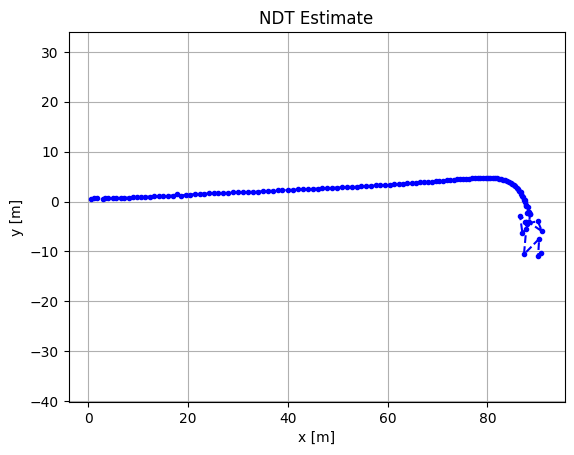

In [ ]:
plt.plot(x_ndt, y_ndt, 'b.--')
plt.title("NDT Estimate")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis('equal')
plt.grid(True)
plt.show()


In [26]:
fde_icp = FDE(x_icp, y_icp, x_gt, y_gt)
ade_icp = ADE(x_icp, y_icp, x_gt, y_gt)
fde_ndt = FDE(x_ndt, y_ndt, x_gt, y_gt)
ade_ndt = ADE(x_ndt, y_ndt, x_gt, y_gt)

print(f"ICP → FDE: {fde_icp:.3f} m, ADE: {ade_icp:.3f} m")
print(f"NDT → FDE: {fde_ndt:.3f} m, ADE: {ade_ndt:.3f} m")

ICP → FDE: 79.409 m, ADE: 58.216 m
NDT → FDE: 80.890 m, ADE: 58.318 m


In [27]:
print(f"{'Method':<10} | {'FDE (m)':<10} | {'ADE (m)':<10}")
print("-" * 32)
print(f"{'ICP':<10} | {fde_icp:.3f}     | {ade_icp:.3f}")
print(f"{'NDT':<10} | {fde_ndt:.3f}     | {ade_ndt:.3f}")


Method     | FDE (m)    | ADE (m)   
--------------------------------
ICP        | 79.409     | 58.216
NDT        | 80.890     | 58.318
